# Baseball salary analysis
## Flow
1. Increase in total league salary over time As compared to a variety of market metrics
2. Team salary graph over time. Point out notable teams. Compare both %spending and #rank
3. The big question - does money buy wins?
    1. All year plot of wins (or win%) vs %spending. Draw conclusions
    2. Plot of Slope of line from year to year with 95% CI error bars
    3. dStd over time - has the spending of money become more or less diverse?
4. Assuming we see a minimal correlation between money and success, what is our hypothesis? Of late - 6 yr team ownership. Plot wins vs salary but color/size dots based on team avg age.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import datetime
import matplotlib
import statsmodels.api as sm

plt.rc('font', size=16)

In [2]:
# Some payroll data from http://www.baseballchronology.com/Baseball/Years/1977
try:
    xl_file = pd.ExcelFile(r'C:\Users\Tyler\Google Drive\DOCUMENTS\Blog Data\Baseball Salary\BaseballStats.xlsx')
except:
    xl_file = pd.ExcelFile(r'C:\Users\thartley\Desktop\BaseballStats.xlsx')
salaries = xl_file.parse(sheetname='Salaries')
allstats = xl_file.parse(sheetname='Statistics')

allstats.Team = allstats.Team.map(lambda x: x.replace(u'\xa0', u" ")) #ascii issue; thanks, excel
allstats.Playoffs.fillna('None', inplace=True)
allstats.Playoffs = allstats.Playoffs.map(lambda x: x.replace(u'\xa0', u" "))


allstats = pd.merge(allstats, salaries, how='left')
# let's play with a subset of data anyways
stats = allstats.reindex(columns=['Team', 'Year', 'W', 'L', 'Salary', 'Playoffs'])
stats.columns = [c.lower() for c in stats.columns]
del salaries # clear up some mem
del allstats # clear up some mem


In [3]:
# Clean up salary data because, again, Excel is the worst.
def to_float(x):
    try:
        return float(x)    
    except:
        return float(x.replace(',','').strip())
    
stats.salary = stats.salary.map(to_float)

In [4]:
# Fix the weird MLB name issues
def team_groups(name):
    # Edge cases - 
    # 1. Anaheim/LA/Etc Angels
    # 2. Devil Rays vs Rays
    # 3. Miami/Florida Marlins
    if 'Angels' in name:
        return 'Los Angeles Angels'
    elif 'Tampa Bay' in name:
        return 'Tampa Bay Rays'
    elif 'Marlins' in name:
        return 'Miami Marlins'
    else:
        return name

stats.team = stats.team.map(team_groups)

In [5]:
# Let's just look at years where we have salary info
stats = stats[stats.year > 1976].reset_index(drop=True)

In [6]:
# Find the team rank in salary for each year
def add_rank(group):
    group['rank_salary'] = group.salary.rank(ascending=False)
    return group
stats = stats.groupby('year').apply(add_rank)

# Compute the number of standard deviations above the mean
def add_median(group):
    group['std_salary'] = (group.salary - group.salary.mean())/group.salary.std()
    return group
stats = stats.groupby('year').apply(add_median)

# Compute the MAD (median absolute deviation)
def add_mad(group):
    median = group.salary.median()
    mad = (group.salary - median).abs().median()*1.4826
    group['mad_salary'] = (group.salary - median)/mad
    return group
stats = stats.groupby('year').apply(add_mad)

# Add Win%
stats['wpct'] = stats.w.astype(float)/(stats.w + stats.l)
stats['expected_wins'] = stats.wpct * 162

# Total League Salary

In [6]:
league_salary = stats.groupby('year').salary.sum()
league_salary.index = league_salary.index.map(lambda x: datetime.datetime(x, 1, 1, 0, 0, 0))

In [33]:
try:
    ff = pd.ExcelFile(r'C:\Users\thartley\Documents\Dropbox\prices.xlsx')
except:
    ff = pd.ExcelFile(r'C:\Users\Tyler\Google Drive\DOCUMENTS\Blog Data\Baseball Salary\prices.xlsx')
    nd = pd.ExcelFile(r'C:\Users\Tyler\Google Drive\DOCUMENTS\Blog Data\Baseball Salary\nasdaq.xlsx')
                      
incomes = ff.parse('household')
incomes = incomes[incomes.year > 1976].sort(columns='year').reset_index(drop=True)

textbooks = ff.parse('textbooks')
#textbooks = pd.DataFrame([textbooks.ix[i] for i in range(0, len(textbooks), 12)])
textbooks['year'] = textbooks.month.map(lambda x: x.year)
textbooks = textbooks[textbooks.year > 1976].reset_index(drop=True)

nasdaq = nd.parse('table (2)').sort(columns='Date')
nasdaq.index = nasdaq.Date
nasdaq = nasdaq.Close

nominal = incomes.nominal
nominal.index = incomes.year.map(lambda x: datetime.datetime(x, 1, 1, 0, 0, 0))
textbook = textbooks.CPI
textbook.index = textbooks.month

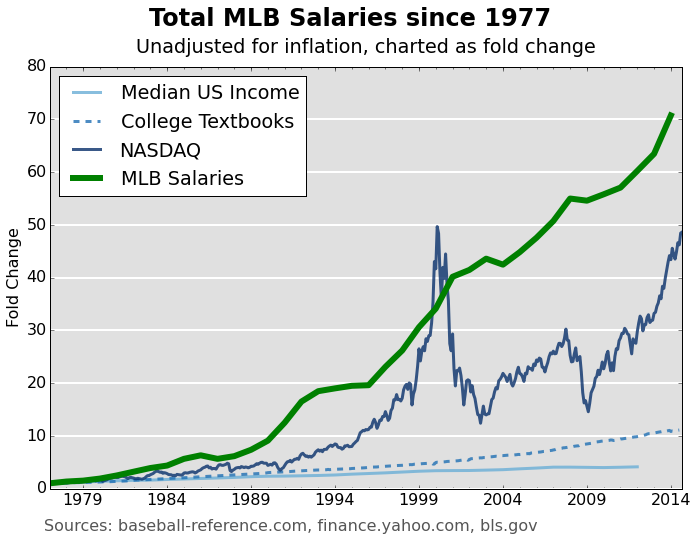

In [48]:
fig = plt.figure(figsize=(10,7))
plt.rc('font', size=16)
cm = plt.get_cmap('Blues')
ax = fig.add_subplot(111, axisbg='#E0E0E0')
linewidth=3
alpha = 0.8
num_lines = 4

(nominal/nominal[0]).plot(color=cm(2./num_lines), linewidth=linewidth, label='Median US Income', alpha=alpha)
(textbook/textbook[0]).plot(color=cm(3./num_lines), linewidth=linewidth, style='--', label='College Textbooks', alpha=alpha)
(nasdaq/nasdaq[0]).plot(color=cm(4./num_lines), linewidth=linewidth, label='NASDAQ', alpha=alpha)
(league_salary/float(league_salary[0])).plot(color='g', linewidth=6, marker='', label='MLB Salaries')

#http://www.etforecasts.com/products/ES_pcww1203.htm
leg = plt.legend(loc='upper left')
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
ax.grid(axis='x')
ax.set_axisbelow(True)

#ax.tick_params(labelsize=16)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Fold Change', fontsize=16)

fig.suptitle("Total MLB Salaries since 1977", 
             fontdict={'size':24, 'fontweight':'bold'}, y=1.03)
ax.set_title('Unadjusted for inflation, charted as fold change', y=1.02)
#ax.set_position([0, 0.2, 1, 0.8])

ax.text(80, -8.0, 'Sources: baseball-reference.com, finance.yahoo.com, bls.gov', color='#555555')
plt.tight_layout()
plt.savefig(r'C:\Users\Tyler\Desktop\foo.png', dpi=300)

# Team Salary over Time

In [16]:
# Find the team rank in salary for each year
def add_rank(group):
    group['rank_salary'] = group.salary.rank(ascending=False)
    return group
stats = stats.groupby('year').apply(add_rank)

# Compute the number of standard deviations above the mean
def add_median(group):
    group['std_salary'] = (group.salary - group.salary.mean())/group.salary.std()
    return group
stats = stats.groupby('year').apply(add_median)

# Compute the MAD (median absolute deviation)
def add_mad(group):
    median = group.salary.median()
    mad = (group.salary - median).abs().median()*1.4826
    group['mad_salary'] = (group.salary - median)/mad
    return group
stats = stats.groupby('year').apply(add_mad)

In [20]:
byteam = stats.groupby('team')

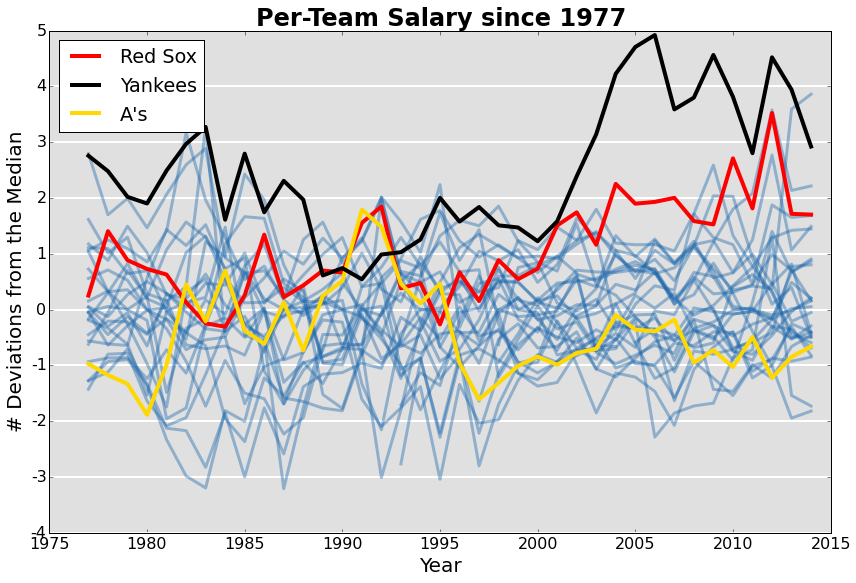

In [21]:
plt.rc('font', size=16)
cm = plt.get_cmap('Blues')
fig = plt.figure(figsize=(14,9))
ax = fig.add_subplot(111, axisbg='#E0E0E0')

for i, g in byteam:
    kwargs = {'color':cm(0.8), 'zorder':1,
            'alpha':0.4, 'linewidth':3,
            'label':None
            }
    if 'Yankees' in i:
        kwargs = {'color':'k', 'zorder':3,
            'alpha':1, 'linewidth':4,
            'label':'Yankees'
            }
        label = 'Yankees'
    if 'Red Sox' in i:
        kwargs = {'color':'r', 'zorder':2,
            'alpha':1, 'linewidth':4,
            'label':'Red Sox'
            }
    if 'Oakland' in i:
        kwargs = {'color':'#FFD800', 'zorder':2,
            'alpha':1, 'linewidth':4,
            'label':'A\'s'
            }
    
    plt.plot(g.year, g.mad_salary, **kwargs)
    
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
ax.set_axisbelow(True)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('# Deviations from the Median', fontsize=20)
formatter = matplotlib.ticker.FormatStrFormatter('%0.0f')
ax.yaxis.set_major_formatter(formatter)
ax.set_title("Per-Team Salary since 1977", fontdict={'size':24, 'fontweight':'bold'})
ax.legend(loc='upper left')

#plt.savefig(r'C:\Users\Tyler\Desktop\foo.png', dpi=300)

# Wins vs Cost

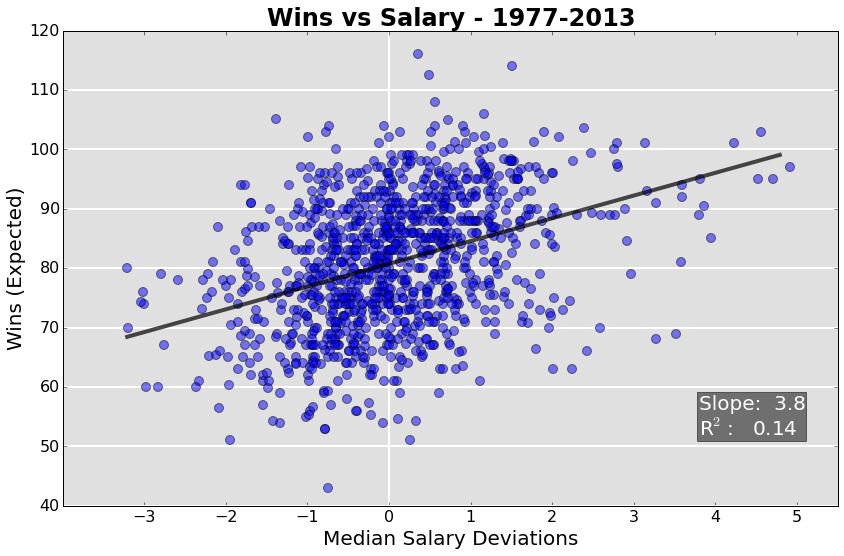

In [8]:
# Plot of all teams & all salaries vs Salary deviations

metric = 'mad_salary'
step = 40
cm = plt.get_cmap('Blues')

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1, 1, 1,  axisbg='#E0E0E0')
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')

# Select subset of data to plot
decade = stats

# Produce a linear fit for the selected data metric
x = decade[metric].as_matrix()
x = sm.add_constant(x)
est = sm.OLS(decade['expected_wins'], x)
res = est.fit()

fakedata = np.arange(decade[metric].min(), decade[metric].max(), 0.4)
fakedata = sm.add_constant(fakedata)
y_hat = res.predict(fakedata)
plt.plot(fakedata[:,1], y_hat, 'k-', linewidth=4, alpha=0.7, zorder=1)

# Plot all team data from this period
plt.scatter(decade[metric], decade.expected_wins, s=80, alpha=0.5)
plt.title("Wins vs Salary - 1977-2013",
          fontdict={'size':24, 'fontweight':'bold'})

plt.plot([0,0], [40, 120], 'w', linewidth=2, zorder=0)
ax.set_axisbelow(True)
ax.set_ylim([40, 120])
ax.set_xlim([-4, 5.5])
ax.set_xticks(np.arange(-3, 6, 1))
plt.xlabel("Median Salary Deviations", fontsize=20)
plt.ylabel("Wins (Expected)", fontsize=20)

text = "Slope:\t%0.1f\nR$^2$:\t %0.2f"%(res.params[1], res.rsquared)
plt.text(3.8, 52, text.expandtabs(), fontsize=20, color='w', bbox=dict(facecolor='k', alpha=0.5))
plt.tight_layout()
plt.savefig(r'C:\Users\Tyler\Desktop\foo.png', dpi=300)

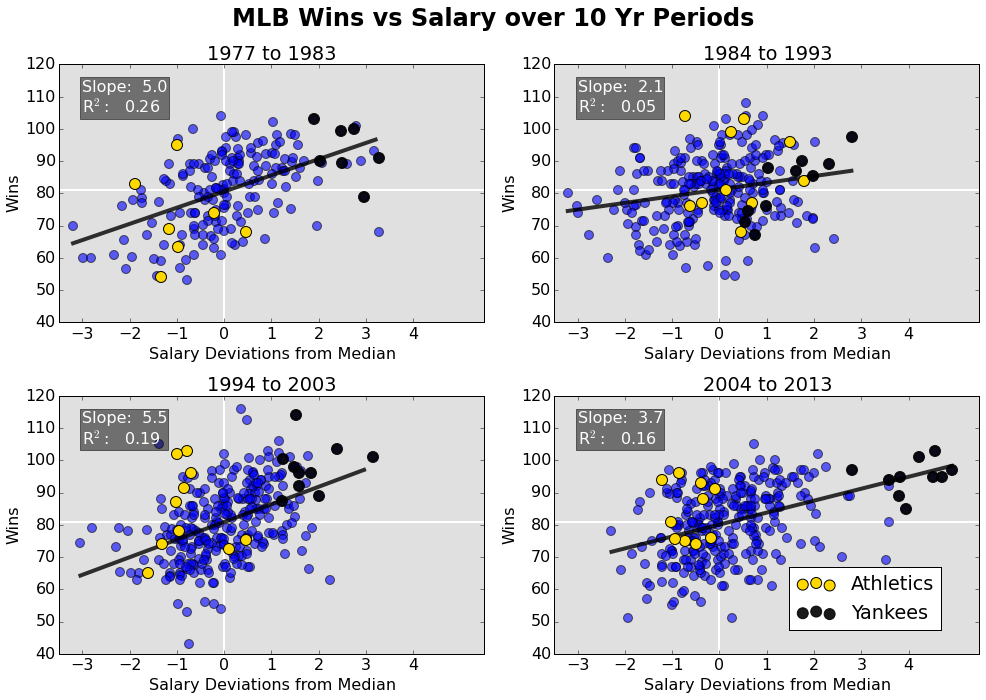

In [19]:
metric = 'mad_salary'
blend = False
step = 10
yrs = [1977, 1984, 1994, 2004, 2014]
cm = plt.get_cmap('Blues')

fig = plt.figure(figsize=(14,10))
    
for idx in range(len(yrs)-1):
    ax = fig.add_subplot(2, 2, idx+1,  axisbg='#E0E0E0')
    #ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
    
    # Select subset of data to plot
    decade = stats[(stats.year >= yrs[idx]) & (stats.year < yrs[idx+1])]
    
    if blend:
        x = decade.groupby('team').mean()[metric].as_matrix()
        y = decade.groupby('team').mean().expected_wins
    # Produce a linear fit for the selected data metric
    else:
        x = decade[metric].as_matrix()
        y = decade['expected_wins']
    xs = sm.add_constant(x)
    est = sm.OLS(y, xs)
    res = est.fit()
    
    fakedata = np.arange(np.min(x), np.max(x), 0.4)
    fakedata = sm.add_constant(fakedata)
    y_hat = res.predict(fakedata)
    plt.plot(fakedata[:,1], y_hat, c='k', linewidth=4, alpha=0.8, zorder=1)
    
    # Plot all team data from this period
    plt.scatter(x, y, s=80, alpha=0.6)
    if not blend:
        plt.title("%s to %s"%(yrs[idx], yrs[idx+1]-1))
        plt.ylabel("Wins", fontsize=16)
        team = decade[decade.team.str.contains('Athletics')]
        l1=plt.scatter(team[metric], team.expected_wins, c='#FFD800', s=120, zorder=2, label='Athletics')

        team = decade[decade.team.str.contains('Yankees')]
        l2=plt.scatter(team[metric], team.expected_wins, c='k', s=120, zorder=2, alpha=0.9, label='Yankees')
    else:
        plt.title("%s to %s Average"%(yrs[idx], yrs[idx+1]-1))
        plt.ylabel("Avg Wins", fontsize=16)
        team = decade[decade.team.str.contains('Athletics')]
        l1=plt.scatter(team[metric].mean(), team.expected_wins.mean(), c='#FFD800', s=120, zorder=2, label='Athletics')

        team = decade[decade.team.str.contains('Yankees')]
        l2=plt.scatter(team[metric].mean(), team.expected_wins.mean(), c='k', s=120, zorder=2, alpha=0.9, label='Yankees')
    plt.plot([0,0], [40, 120], 'w', linewidth=2, zorder=0)
    plt.plot([-5, 5.5], [81, 81],  'w', linewidth=2, zorder=0)
    ax.set_axisbelow(True)
    ax.set_ylim([40, 120])
    ax.set_xlim([-3.5, 5.5])
    ax.set_xticks(np.arange(-3, 5, 1))
    plt.xlabel("Salary Deviations from Median", fontsize=16)
    
    text = "Slope:\t%0.1f\nR$^2$:\t %0.2f"%(res.params[1], res.rsquared)
    ax.text(-3, 105, text.expandtabs(), fontsize=16, color='w', bbox=dict(facecolor='k', alpha=0.5))
#plt.xlim([-4, 5.5])
#plt.ylim([40, 120])
plt.suptitle("MLB Wins vs Salary over 10 Yr Periods", y=.98, fontdict={'size':24, 'fontweight':'bold'})
fig.legend((l1, l2), ('Athletics', 'Yankees'), loc=(.8, .1))
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(r'C:\Users\Tyler\Desktop\foo.png', dpi=300)

[[1977, 1982, 7.138115186534443], [1982, 1987, 2.6168587052615835], [1987, 1992, 1.7504459975799547], [1992, 1997, 3.1201472367671053], [1997, 2002, 6.05183894750542], [2002, 2007, 5.3535978321761011], [2007, 2012, 3.8025916645189746], [2012, 2014, 2.2243472143235312]]


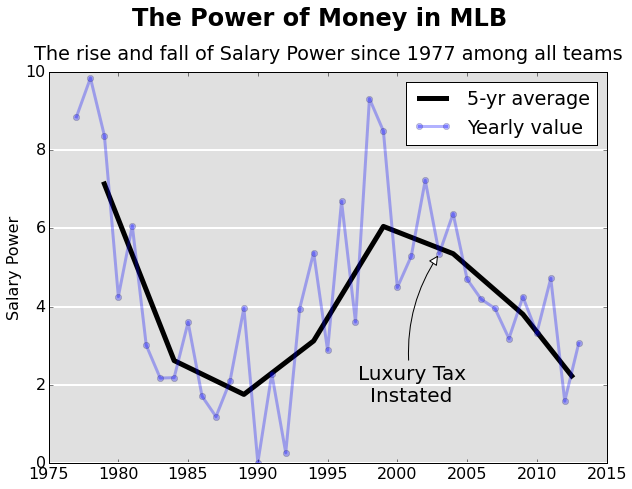

In [26]:
# Plot of Slope for Wins vs $ by year
metric = 'mad_salary'
step = 5
yrs = range(1977, 2014, step)+[2014]

slopes = []

for idx in range(len(yrs)-1):
    yrdata = stats[(stats.year >= yrs[idx]) & (stats.year < yrs[idx+1])]
    
    # Produce a linear fit for the selected data metric
    x = yrdata[metric].as_matrix()
    x = sm.add_constant(x)
    est = sm.OLS(yrdata['expected_wins'], x)
    res = est.fit()
    slopes.append([yrs[idx], yrs[idx+1], res.params[1]])

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111,  axisbg='#E0E0E0')
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
ax.set_axisbelow(True)
plt.plot([x[0]+(x[1]-1-x[0])/2. for x in slopes], [x[2] for x in slopes], 'k-', linewidth=5, label='%s-yr average'%step)
print slopes
# Plot of Slope for Wins vs $ by year
metric = 'mad_salary'
step = 1
yrs = range(1977, 2014, step)+[2014]
slopes = []

for idx in range(len(yrs)-1):
    yrdata = stats[(stats.year >= yrs[idx]) & (stats.year < yrs[idx+1])]
    
    # Produce a linear fit for the selected data metric
    x = yrdata[metric].as_matrix()
    x = sm.add_constant(x)
    est = sm.OLS(yrdata['expected_wins'], x)
    res = est.fit()
    slopes.append([yrs[idx], yrs[idx+1], res.params[1]])
    
plt.plot([x[0] for x in slopes], [x[2] for x in slopes], 'bo-', alpha=0.3, linewidth=3, label='Yearly value')  

# Legends, titles, etc
ann = ax.annotate("Luxury Tax\nInstated",
                  xy=(2003, 5.35), xycoords='data',
                  xytext=(2001, 2), textcoords='data',
                  size=20, va="center", ha="center",
                  #bbox=dict(fc="w"),
                  arrowprops=dict(arrowstyle="-|>",
                                  connectionstyle="arc3,rad=-0.2",
                                  fc="w"),
                  )
plt.suptitle("The Power of Money in MLB", fontdict={'size':24, 'fontweight':'bold'}, y=1.03)
plt.title('The rise and fall of Salary Power since 1977 among all teams', y=1.02)
plt.legend(loc='upper right')
plt.ylabel("Salary Power", fontsize=16)
#plt.xlabel("Year", fontsize=20)

# Bar graph of average wins for each quartile

In [7]:
def playoff_wins(playoff):
    if 'None' in playoff:
        return 0
    if 'NLWC' in playoff or 'ALWC' in playoff or 'LDS' in playoff:
        return int(re.findall('\d', playoff)[1])
    elif 'LCS' in playoff:
        return 3+int(re.findall('\d', playoff)[1])
    elif 'Lost WS' in playoff:
        return 3+4+int(re.findall('\d', playoff)[1])
    elif 'Won' in playoff:
        return 3+4+4   

def renum_playoffs(playoff):
    if 'None' in playoff:
        return 0
    if 'NLWC' in playoff or 'ALWC' in playoff or 'LDS' in playoff:
        return 1
    elif 'LCS' in playoff:
        return 2
    elif 'Lost WS' in playoff:
        return 3
    elif 'Won WS' in playoff:
        return 4

stats['playoff_wins'] = stats.playoffs.map(playoff_wins)
stats['playoffs'] = stats.playoffs.map(renum_playoffs)

In [8]:
stats['quartile'] = pd.qcut(stats.mad_salary, q=[0, .25, .5, .75, 1.], labels=['1', '2', '3', '4'])
import copy
stats_copy = copy.deepcopy(stats)
stats_new = stats_copy[(stats_copy.year >= 2003) & (stats_copy.year < 2103)]
stats_old = stats_copy[(stats_copy.year >= 1995) & (stats_copy.year < 2003)]
stats_since94 = stats[stats.year > 1994]

In [9]:
quartiles_old = stats_old.groupby('quartile')
quartiles_new = stats_new.groupby('quartile')
quartiles = stats_since94.groupby('quartile')

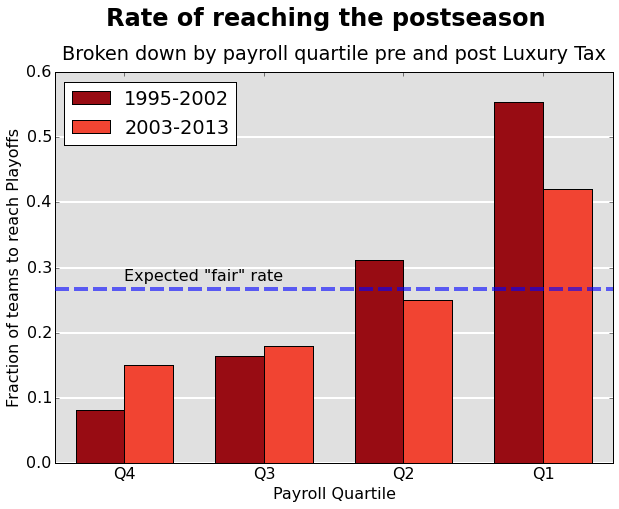

In [48]:
# plot liklihood of making the playoffs from pre and post luxury tax
plt.rc('font', size=16)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, axisbg='#E0E0E0')
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
ax.set_axisbelow(True)

margin = 0.15
width = (1-margin*2)/2
ind = np.arange(4)

cm = plt.get_cmap('Reds')
colors = [cm(c) for c in [0.6,0.7,0.8,0.9]]


ax.bar(ind+margin, quartiles_old.playoffs.agg(lambda x: np.sum(x >= 1))/quartiles_old.playoffs.count(), 
        width, color=cm(0.9), label='1995-2002')
ax.bar(ind+width+margin, quartiles_new.playoffs.agg(lambda x: np.sum(x >= 1))/quartiles_new.playoffs.count(), 
        width, color=cm(0.6), label='2003-2013')
ax.plot([ind[0], ind[3]+width+0.5+margin], [8./30, 8./30], 'b--', linewidth=4, zorder=3, 
        alpha=0.6, dashes=[14, 5])
ax.set_xticks(ind+0.5)
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'][::-1])

ax.legend(loc='upper left')
ax.text(0.5, 0.28, 'Expected \"fair\" rate')
ax.set_ylabel("Fraction of teams to reach Playoffs")
ax.set_xlabel("Payroll Quartile")
ax.set_title("Broken down by payroll quartile pre and post Luxury Tax", y=1.02)
fig.suptitle("Rate of reaching the postseason", fontdict={'size':24, 'fontweight':'bold'}, y=1.03)



In [10]:
# Table of playoff levels reached by quartile
playoff_levels = ['Made LDS/WC', 'Made LCS', 'Made WS' 'Won WS']
stuff = []
for i in range(1, 5): # for each level of playoffs:`
    stuff.append(quartiles.playoffs.agg(lambda x: np.sum(x >= i))/quartiles.mad_salary.count())
table = np.array(stuff).T
print table

[[ 0.11971831  0.04929577  0.02816901  0.00704225]
 [ 0.17419355  0.01290323  0.          0.        ]
 [ 0.27659574  0.17021277  0.09219858  0.04964539]
 [ 0.46794872  0.27564103  0.13461538  0.07051282]]


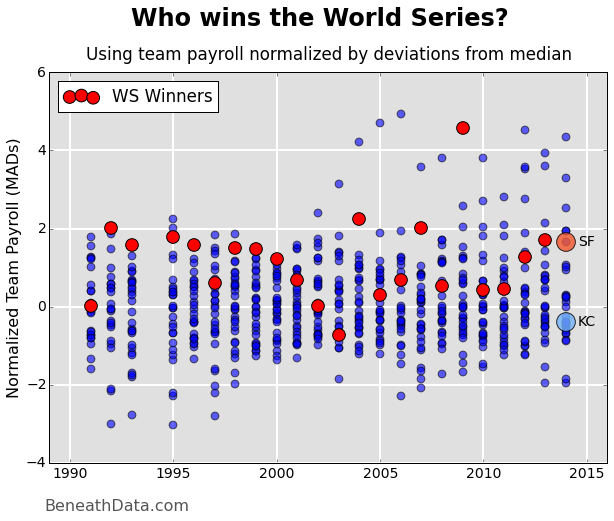

In [36]:
# plot payroll rank of WS winners by year
plt.rc('font', size=14)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, axisbg='#E0E0E0')
ax.grid(axis='y', linewidth=2, ls='-', color='#ffffff')
ax.grid(axis='x', linewidth=2, ls='-', color='#ffffff')
ax.set_axisbelow(True)

cm = plt.get_cmap('Reds')
winners = stats[(stats.year > 1990) & (stats.playoffs == 4)]

for yr in np.arange(1991, 2015):
    if yr == 1994:
        continue
    thisyear = stats[stats.year == yr]
    try:
        plt.scatter(yr, winners[winners.year == yr].mad_salary, edgecolor='k', s=160, color='r', zorder=2)
    except ValueError:
        plt.scatter(yr, thisyear[thisyear.team.str.contains('Royals')].mad_salary, edgecolor='k', s=350, 
                    color='#74B4FA', zorder=2, alpha=0.8)
        ax.text(yr+0.6, thisyear[thisyear.team.str.contains('Royals')].mad_salary-0.1, 'KC')
        plt.scatter(yr, thisyear[thisyear.team.str.contains('Giants')].mad_salary, edgecolor='k', s=350, 
                    color='#F2552C', zorder=2, alpha=0.8)
        ax.text(yr+0.6, thisyear[thisyear.team.str.contains('Giants')].mad_salary-0.1, 'SF')
    plt.scatter(thisyear.year, thisyear.mad_salary, s=60, alpha=0.6, zorder=1)

ax.set_xlim([1989, 2016])
ax.set_ylabel("Normalized Team Payroll (MADs)", fontsize=16)

ax.legend(['WS Winners'], loc='upper left')
fig.suptitle("Who wins the World Series?", fontdict={'size':24, 'fontweight':'bold'}, y=1.03)
ax.set_title("Using team payroll normalized by deviations from median", y=1.02)
fig.text(0.12, 0.03, "BeneathData.com", fontsize=16, color='#555555')
plt.savefig(r'C:\Users\thartley\Desktop\foo.png', dpi=100, bbox_inches='tight', pad_inches=0.5)

## Scratch

In [7]:
st = stats[(stats.year > 1991) & (stats.mad_salary > 2)]

In [10]:
st.team.value_counts()

New York Yankees         14
Boston Red Sox            4
Philadelphia Phillies     4
Los Angeles Dodgers       3
Chicago Cubs              2
Toronto Blue Jays         2
Los Angeles Angels        1
New York Mets             1
dtype: int64

In [11]:
st.year.value_counts()

2012    4
2014    3
2013    3
2010    3
2009    3
2011    2
2007    2
2004    2
1995    2
1992    2
2008    1
2006    1
2005    1
2003    1
2002    1
dtype: int64

In [18]:
st.sort(columns=['team', 'year'])

,team,year,w,l,salary,playoffs,rank_salary,std_salary,mad_salary,wpct,expected_wins
303,Boston Red Sox,2004,98,64,127298500,Won WS (4-0),2,1.776612,2.253552,0.604938,98.000000
213,Boston Red Sox,2007,96,66,143026214,Won WS (4-0),2,1.783402,2.002657,0.592593,96.000000
123,Boston Red Sox,2010,89,73,171072333,None,2,2.075972,2.710404,0.549383,89.000000
63,Boston Red Sox,2012,69,93,173186617,None,3,2.040844,3.522823,0.425926,69.000000
154,Chicago Cubs,2009,83,78,134809000,None,3,1.358061,2.037252,0.515528,83.515528
124,Chicago Cubs,2010,75,87,149309000,None,3,1.513100,2.028839,0.462963,75.000000
72,Los Angeles Angels,2012,89,73,154485166,None,4,1.533069,2.769311,0.549383,89.000000
661,Los Angeles Dodgers,1992,63,99,44788166,None,2,1.508723,2.015159,0.388889,63.000000
43,Los Angeles Dodgers,2013,92,70,216597577,Lost NLCS (4-2),2,2.449215,3.593798,0.567901,92.000000
13,Los Angeles Dodgers,2014,94,68,235295219,Lost LDS (3-1),1,2.790380,4.336953,0.580247,94.000000
